In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import sklearn as sk

import statsmodels.api as sm

import pandas_datareader as web
from datetime import date, datetime
from pandas.tseries.offsets import BDay

pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.filterwarnings("ignore")

In [115]:
start = date(1990, 1, 1)
end = date.today()

In [116]:
# Import data

yahoo_names = {'spy': 'SPY',
               'US_bond13w': '^IRX',
               'US_bond5y': '^FVX',
               'US_bond10y': '^TNX'}

for key, value in yahoo_names.items():
    globals()[key] = web.DataReader(value, 'yahoo', start, end)
    

csv_directories = {'gold': 'gold_price.csv',
                   'silver': 'silver_price.csv',
                   'copper': 'copper_price.csv',
                   'corn': 'corn_price.csv',
                   'sugar': 'sugar_price.csv',
                   'wheat': 'wheat_price.csv',
                   'WTcrudeoil': 'WTcrudeoil_price.csv',
#                   'CN_bond1y': 'China 1-Year Bond Yield Historical Data.csv',
#                   'CN_bond5y': 'China 5-Year Bond Yield Historical Data.csv',
#                   'CN_bond10y': 'China 10-Year Bond Yield Historical Data.csv',
#                   'UK_bond1y': 'United Kingdom 1-Year Bond Yield Historical Data.csv',
#                   'UK_bond5y': 'United Kingdom 5-Year Bond Yield Historical Data.csv',
#                   'UK_bond10y': 'United Kingdom 10-Year Bond Yield Historical Data.csv',
#                   'US_bond1y': 'United States 1-Year Bond Yield Historical Data.csv',
#                   'US_bond5y_1': 'United States 5-Year Bond Yield Historical Data (1).csv',
#                   'US_bond5y_2': 'United States 5-Year Bond Yield Historical Data.csv',
#                   'US_bond10y_1': 'United States 10-Year Bond Yield Historical Data (2).csv',
#                   'US_bond10y_2': 'United States 10-Year Bond Yield Historical Data (1).csv',
#                   'US_bond10y_3': 'United States 10-Year Bond Yield Historical Data.csv',
#                   'US_yield1y': '1-year-treasury-rate-yield-chart.csv',
#                   'US_yield5y': '5-year-treasury-bond-rate-yield-chart.csv',
#                   'US_yield10y': '10-year-treasury-bond-rate-yield-chart.csv',
                   'EM_index': 'MSCI EM Index.csv'}

for key, value in csv_directories.items():
    if '_bond' in key:
        globals()[key] = pd.read_csv('data/' + value, index_col=0)[::-1]
    else:
        globals()[key] = pd.read_csv('data/' + value, index_col=0)

In [117]:
spread = (US_bond10y['Close'] - US_bond13w['Close'])
spread_change = np.abs((spread - spread.shift(1)).dropna())
spread_change

Date
1990-01-03   0.00000
1990-01-04   0.03000
1990-01-05   0.06000
1990-01-08   0.03000
1990-01-09   0.01000
               ...  
2021-04-22   0.01200
2021-04-23   0.01300
2021-04-26   0.01000
2021-04-27   0.05000
2021-04-28   0.02100
Name: Close, Length: 7826, dtype: float64

In [118]:
spy['Change'] = ((spy['Adj Close'] / spy.shift(1)['Adj Close']) - 1)
spy.dropna(subset=['Change'], inplace=True)
spy

,High,Low,Open,Close,Volume,Adj Close,Change
Date,,,,,,,
1993-02-01,44.25000,43.96875,43.96875,44.25000,480500.00000,26.06828,0.00711
1993-02-02,44.37500,44.12500,44.21875,44.34375,201300.00000,26.12350,0.00212
1993-02-03,44.84375,44.37500,44.40625,44.81250,529400.00000,26.39965,0.01057
1993-02-04,45.09375,44.46875,44.96875,45.00000,531500.00000,26.51011,0.00418
1993-02-05,45.06250,44.71875,44.96875,44.96875,492100.00000,26.49171,-0.00069
...,...,...,...,...,...,...,...
2021-04-22,416.78000,411.13000,415.89001,412.26999,97582800.00000,412.26999,-0.00913
2021-04-23,418.25000,412.79001,412.87000,416.73999,73209200.00000,416.73999,0.01084
2021-04-26,418.22000,416.81000,417.44000,417.60999,52182400.00000,417.60999,0.00209


In [119]:
# Simple rule: Hold SPY if the 10-year minus 13-week spread changes less than 0.09, else do not hold
# Did not include the effect of commission fee

holds = spread_change.apply(lambda x: 0 if x > 0.09 else 1)
holds_change = (holds.shift(1) * spy['Change']).dropna()  # shift(1) because only spread for date t-1 is available for date t
holds_change

Date
1993-02-01    0.00711
1993-02-02    0.00212
1993-02-03    0.01057
1993-02-04    0.00418
1993-02-05   -0.00069
               ...   
2021-04-22   -0.00913
2021-04-23    0.01084
2021-04-26    0.00209
2021-04-27   -0.00022
2021-04-28    0.00091
Length: 7057, dtype: float64

In [120]:
print(np.prod(holds_change + 1), np.prod(spy['Change'] + 1))

17.93603009268276 16.144994015445178


Text(0, 0.5, 'Hold = 1')

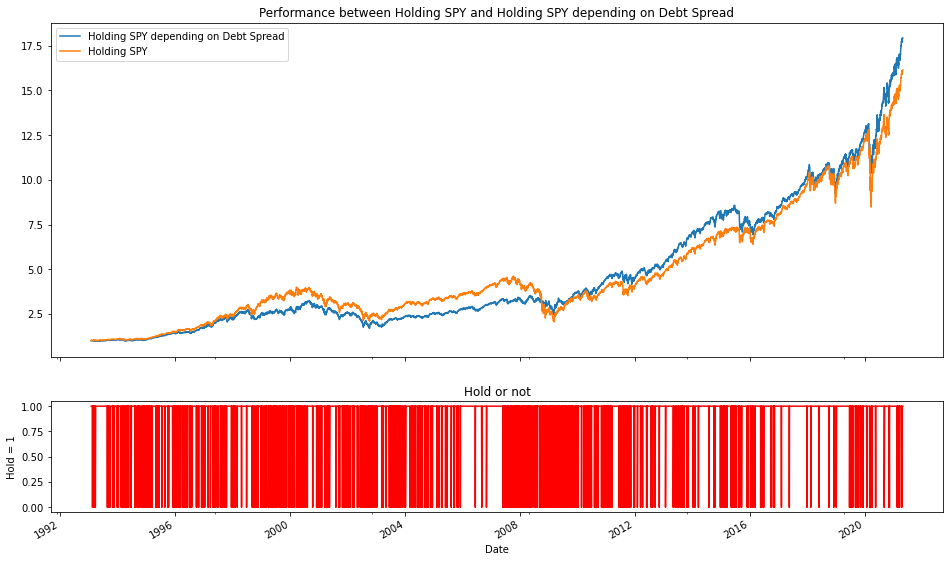

In [121]:
fig, ax = plt.subplots(2, 1, figsize=(16,10),
                       gridspec_kw={'height_ratios': [3, 1]},
                       sharex=True)

(holds_change + 1).cumprod().plot(ax=ax[0],
                                  title='Performance between Holding SPY and Holding SPY depending on Debt Spread',
                                  label='Holding SPY depending on Debt Spread')
(spy['Change'] + 1).cumprod().plot(ax=ax[0],
                                   label='Holding SPY')

ax[0].legend()

holds.loc[spy.index[0]:].plot(ax=ax[1], color='red', title='Hold or not')
ax[1].set_ylabel('Hold = 1')

It seems like there is a chance this strategy is able to avoid big drops:
- Almost completely avoided 2008 financial crisis
- Suffer less lost on March 2020 plunge

In [135]:
returns, turnover_rates = {}, {}
total_dates = len(spy) - 1

for i in np.arange(0.01, 0.5, 0.01):
    holds_ = spread_change.apply(lambda x: 0 if x > i else 1)
    holds_change_ = (holds_.shift(1) * spy['Change']).dropna()
    returns[i] = np.prod(holds_change_ + 1)
    
    turnover_rates[i] = np.sum(np.abs(holds_ - holds_.shift(1))) / total_dates

<AxesSubplot:xlabel='Threshold of T-bill Spread', ylabel='Cumulative Return from 1993-02-01'>

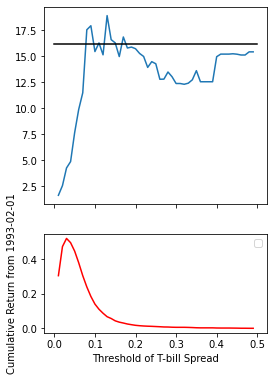

In [145]:
fig, ax = plt.subplots(2, 1, figsize=(4,6),
                       gridspec_kw={'height_ratios': [2, 1]},
                       sharex=True)

pd.Series(returns).plot(ax=ax[0])
ax[0].plot([0, 0.5], [16.13031304715503, 16.13031304715503], color='black')
plt.xlabel('Threshold of T-bill Spread')
plt.ylabel('Cumulative Return from 1993-02-01')
plt.legend(['Returns', 'Benchmark'])

pd.Series(turnover_rates).plot(ax=ax[1], color='red')

In [130]:
for i in np.arange(0.01, 0.5, 0.01):

Date
1990-01-02   0.36000
1990-01-03   0.36000
1990-01-04   0.39000
1990-01-05   0.45000
1990-01-08   0.48000
               ...  
2021-04-22   1.53900
2021-04-23   1.55200
2021-04-26   1.56200
2021-04-27   1.61200
2021-04-28   1.63300
Name: Close, Length: 7827, dtype: float64

In [124]:
debt_spread_10y_13w = US_bond10y['Close'] - US_bond13w['Close']
debt_spread_10y_5y = US_bond10y['Close'] - US_bond5y['Close']
debt_spread_5y_13w = US_bond5y['Close'] - US_bond13w['Close']


df = pd.DataFrame({
    'SPY_change': ((spy['Adj Close'] / spy.shift(1)['Adj Close']) - 1),
    'Debt Spread (10y - 13w)_t-1': debt_spread_10y_13w.shift(1),
    'Debt Spread (10y - 5y)_t-1': debt_spread_10y_5y.shift(1),
    'Debt Spread (5y - 13w)_t-1': debt_spread_5y_13w.shift(1),
    'Debt Spread Change (10y - 13w)_t-1': (debt_spread_10y_13w - debt_spread_10y_13w.shift(1)).shift(1),
    'Debt Spread Change (10y - 5y)_t-1': (debt_spread_10y_5y - debt_spread_10y_5y.shift(1)).shift(1),
    'Debt Spread Change (5y - 13w)_t-1': (debt_spread_5y_13w - debt_spread_5y_13w.shift(1)).shift(1),
})

for i in [1,2,3,4,5]:
    df['Debt Spread (10y - 13w)_t-' + str(i)] = debt_spread_10y_13w.shift(i)
    df['Debt Spread (10y - 5y)_t-' + str(i)] = debt_spread_10y_5y.shift(i)
    df['Debt Spread (5y - 13w)_t-' + str(i)] = debt_spread_5y_13w.shift(i)
    df['Debt Spread Change (10y - 13w)_t-' + str(i)] = (debt_spread_10y_13w - debt_spread_10y_13w.shift(1)).shift(i)
    df['Debt Spread Change (10y - 5y)_t-' + str(i)] = (debt_spread_10y_5y - debt_spread_10y_5y.shift(1)).shift(i)
    df['Debt Spread Change (5y - 13w)_t-' + str(i)] = (debt_spread_5y_13w - debt_spread_5y_13w.shift(1)).shift(i)
    df['Abs Debt Spread Change (10y - 13w)_t-' + str(i)] = np.abs(df['Debt Spread Change (10y - 13w)_t-' + str(i)])
    df['Abs Debt Spread Change (10y - 5y)_t-' + str(i)] = np.abs(df['Debt Spread Change (10y - 5y)_t-' + str(i)])
    df['Abs Debt Spread Change (5y - 13w)_t-' + str(i)] = np.abs(df['Debt Spread Change (5y - 13w)_t-' + str(i)])

df.dropna(inplace=True)

X = df.drop('SPY_change', axis=1)
Y = df['SPY_change']

In [125]:
sm.OLS(Y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SPY_change   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.345
Date:                Wed, 28 Apr 2021   Prob (F-statistic):           0.000100
Time:                        23:25:17   Log-Likelihood:                 21285.
No. Observations:                7056   AIC:                        -4.251e+04
Df Residuals:                    7028   BIC:                        -4.232e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.0007      0.000      1.944      0.052   -5.58e-06       0.001
Debt Spread (10y - 13w)_t-1               -0.0003      0.001     -0.241      0.809      -0.002       0.002
Debt Spread (10y - 5y)_t-1                -0.0002      0.002     -0.107      0.915      -0.004       0.004
Debt Spread (5y - 13w)_t-1             -4.302e-05      0.001     -0.038      0.970      -0.002       0.002
Debt Spread Change (10y - 13w)_t-1         0.0003      0.002      0.181      0.857      -0.003       0.004
Debt Spread Change (10y - 5y)_t-1          0.0030      0.003      0.936      0.350      -0.003       0.009
Debt Spread Change (5y - 13w)_t-1         -0.0027      0.002     -1.489      0.136      -0.006       0.001
Abs Debt Spread Change (10y - 13w)_t-1     0.0229      0.008      2.789      0.005       0.007       0.039
Abs Debt Spread Change (10y - 5y)_t-1     -0.0106      0.011     -0.949      0.343      -0.032       0.011
Abs Debt Spread Change (5y - 13w)_t-1     -0.0223      0.008     -2.665      0.008      -0.039      -0.006
Debt Spread (10y - 13w)_t-2               -0.0006      0.001     -0.537      0.591      -0.003       0.001
Debt Spread (10y - 5y)_t-2                -0.0032      0.002     -1.630      0.103      -0.007       0.001
Debt Spread (5y - 13w)_t-2                 0.0026      0.001      2.384      0.017       0.000       0.005
Debt Spread Change (10y - 13w)_t-2         0.0011      0.002      0.642      0.521      -0.002       0.004
Debt Spread Change (10y - 5y)_t-2         -0.0023      0.003     -0.763      0.445      -0.008       0.004
Debt Spread Change (5y - 13w)_t-2          0.0034      0.002      1.982      0.047    3.76e-05       0.007
Abs Debt Spread Change (10y - 13w)_t-2    -0.0152      0.008     -1.855      0.064      -0.031       0.001
Abs Debt Spread Change (10y - 5y)_t-2     -0.0054      0.011     -0.481      0.630      -0.027       0.017
Abs Debt Spread Change (5y - 13w)_t-2      0.0108      0.008      1.287      0.198      -0.006       0.027
Debt Spread (10y - 13w)_t-3               -0.0016      0.001     -1.506      0.132      -0.004       0.000
Debt Spread (10y - 5y)_t-3                -0.0008      0.002     -0.415      0.678      -0.005       0.003
Debt Spread (5y - 13w)_t-3                -0.0008      0.001     -0.703      0.482      -0.003       0.001
Debt Spread Change (10y - 13w)_t-3        -0.0024      0.002     -1.422      0.155      -0.006       0.001
Debt Spread Change (10y - 5y)_t-3         -0.0005      0.003     -0.152      0.879      -0.006       0.006
Debt Spread Change (5y - 13w)_t-3         -0.0019      0.002     -1.099      0.272      -0.005       0.001
Abs Debt Spread Change (10y - 13w)_t-3    -0.0059      0.008     -0.714      0.476     

## Machine Learning

In [242]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [200]:
split = 0.75

X_train, Y_train = X.iloc[:int(len(spy) * split)], Y.iloc[:int(len(spy) * split)]
X_test, Y_test = X.iloc[int(len(spy) * split):], Y.iloc[int(len(spy) * split):]

In [201]:
X_train.tail()

,Debt Spread (10y - 13w)_t-1,Debt Spread (10y - 5y)_t-1,Debt Spread (5y - 13w)_t-1,Debt Spread Change (10y - 13w)_t-1,Debt Spread Change (10y - 5y)_t-1,Debt Spread Change (5y - 13w)_t-1,Abs Debt Spread Change (10y - 13w)_t-1,Abs Debt Spread Change (10y - 5y)_t-1,Abs Debt Spread Change (5y - 13w)_t-1,Debt Spread (10y - 13w)_t-2,...,Abs Debt Spread Change (5y - 13w)_t-4,Debt Spread (10y - 13w)_t-5,Debt Spread (10y - 5y)_t-5,Debt Spread (5y - 13w)_t-5,Debt Spread Change (10y - 13w)_t-5,Debt Spread Change (10y - 5y)_t-5,Debt Spread Change (5y - 13w)_t-5,Abs Debt Spread Change (10y - 13w)_t-5,Abs Debt Spread Change (10y - 5y)_t-5,Abs Debt Spread Change (5y - 13w)_t-5
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-29,2.41000,0.96700,1.44300,-0.08000,-0.02200,-0.05800,0.08000,0.02200,0.05800,2.49000,...,0.02500,2.51200,1.01600,1.49600,0.02800,0.01300,0.01500,0.02800,0.01300,0.01500
2014-05-30,2.41700,0.93400,1.48300,0.00700,-0.03300,0.04000,0.00700,0.03300,0.04000,2.41000,...,0.02000,2.52700,1.00600,1.52100,0.01500,-0.01000,0.02500,0.01500,0.01000,0.02500
2014-06-02,2.42700,0.92900,1.49800,0.01000,-0.00500,0.01500,0.01000,0.00500,0.01500,2.41700,...,0.00000,2.50800,1.00700,1.50100,-0.01900,0.00100,-0.02000,0.01900,0.00100,0.02000
2014-06-03,2.50900,0.93800,1.57100,0.08200,0.00900,0.07300,0.08200,0.00900,0.07300,2.42700,...,0.05800,2.49000,0.98900,1.50100,-0.01800,-0.01800,0.00000,0.01800,0.01800,0.00000
2014-06-04,2.56300,0.95700,1.60600,0.05400,0.01900,0.03500,0.05400,0.01900,0.03500,2.50900,...,0.04000,2.41000,0.96700,1.44300,-0.08000,-0.02200,-0.05800,0.08000,0.02200,0.05800


In [206]:
std = StandardScaler().fit(X_train)

X_train_std = pd.DataFrame(std.transform(X_train), index=X_train.index)
X_test_std = pd.DataFrame(std.transform(X_test), index=X_test.index)

In [207]:
sm.OLS(Y_train, sm.add_constant(X_train_std)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SPY_change   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.884
Date:                Thu, 29 Apr 2021   Prob (F-statistic):            0.00372
Time:                        11:49:54   Log-Likelihood:                 15991.
No. Observations:                5334   AIC:                        -3.193e+04
Df Residuals:                    5306   BIC:                        -3.174e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.483      0.013    8.67e-05       0.001
0          -4.268e-06   1.59e-05     -0.268      0.788   -3.54e-05    2.69e-05
1           3.364e-05   4.17e-05      0.807      0.420   -4.81e-05       0.000
2          -2.512e-05   3.33e-05     -0.754      0.451   -9.04e-05    4.02e-05
3           4.129e-05   8.65e-05      0.477      0.633      -0.000       0.000
4              0.0002      0.000      1.358      0.174   -9.69e-05       0.001
5          -2.495e-05   8.98e-05     -0.278      0.781      -0.000       0.000
6              0.0009      0.000      2.052      0.040    4.11e-05       0.002
7          -8.058e-06      0.000     -0.044      0.965      -0.000       0.000
8             -0.0009      0.000     -2.020      0.043      -0.002   -2.65e-05
9          -6.791e-06   1.52e-05     -0.446      0.655   -3.66e-05     2.3e-05
10          2.388e-05   4.14e-05      0.577      0.564   -5.73e-05       0.000
11         -2.303e-05   3.26e-05     -0.707      0.480   -8.69e-05    4.08e-05
12             0.0002   8.62e-05      2.032      0.042    6.14e-06       0.000
13            -0.0001      0.000     -0.884      0.377      -0.000       0.000
14             0.0002   8.95e-05      2.477      0.013    4.62e-05       0.000
15            -0.0004      0.000     -0.957      0.339      -0.001       0.000
16            -0.0001      0.000     -0.599      0.549      -0.000       0.000
17             0.0003      0.000      0.601      0.548      -0.001       0.001
18         -1.749e-05   1.49e-05     -1.172      0.241   -4.68e-05    1.18e-05
19          3.024e-05   4.14e-05      0.730      0.466    -5.1e-05       0.000
20         -4.148e-05   3.23e-05     -1.282      0.200      -0.000    2.19e-05
21            -0.0001   8.63e-05     -1.413      0.158      -0.000    4.72e-05
22            -0.0002      0.000     -1.267      0.205      -0.001       0.000
23          -6.17e-05   8.96e-05     -0.689      0.491      -0.000       0.000
24            -0.0003      0.000     -0.761      0.447      -0.001       0.001
25             0.0002      0.000      1.143      0.253      -0.000       0.001
26          3.708e-05      0.000      0.084      0.933      -0.001       0.001
27         -1.003e-05   1.51e-05     -0.667      0.505   -3.95e-05    1.95e-05
28          3.934e-05   4.17e-05      0.943      0.346   -4.24e-05       0.000
29         -3.633e-05   3.25e-05     -1.116      0.264      -0.000    2.75e-05
30             0.0002   8.64e-05      2.292      0.022    2.86e-05       0.000
31            -0.0003      0.000     -1.671      0.095      -0.001    4.65e-05
32             0.0003   8.98e-05      3.162      0.002       0.000       0.000
33             0.0009      0.000      1.911      0.056   -2.23e-05       0.002
34            -0.0003      0.000     -1.465      0.143      -0.001    9.04e-05
35

In [208]:
# Linear Regression
from sklearn.linear_model import LinearRegression

ols = LinearRegression().fit(X_train_std, Y_train)
ols_pred = ols.predict(X_test_std)

In [237]:
# Lasso
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X_train_std, Y_train)
lasso_pred = lasso.predict(X_test_std)

In [238]:
# Ridge
from sklearn.linear_model import RidgeCV

ridge = RidgeCV().fit(X_train_std, Y_train)
ridge_pred = ridge.predict(X_test_std)

In [239]:
# Elastic Net
from sklearn.linear_model import ElasticNetCV

elasticnet = ElasticNetCV().fit(X_train_std, Y_train)
elasticnet_pred = elasticnet.predict(X_test_std)

In [257]:
np.arange(0.01, 0.1, 0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [270]:
# Support Vector Machine
from sklearn.svm import LinearSVR

grid_svr = {
    'C': np.arange(0.01, 0.11, 0.01),
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
}

gs_svr = GridSearchCV(LinearSVR(), grid_svr, n_jobs=3, verbose=2, cv=3)
gs_svr.fit(X_train_std, Y_train)

svm = LinearSVR(C=gs_svr.best_params_['C'], loss=gs_svr.best_params_['loss']).fit(X_train_std, Y_train)
svm_pred = svm.predict(X_test_std)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    9.0s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:   17.2s finished


In [293]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

grid_DT = {
    'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
    'min_samples_split': [100, 200, 500, 1000]
}

gs_DT = GridSearchCV(DecisionTreeRegressor(), grid_DT, n_jobs=3, verbose=2, cv=3)
gs_DT.fit(X_train_std, Y_train)

DT = DecisionTreeRegressor(criterion=gs_DT.best_params_['criterion'],
                           min_samples_split=gs_DT.best_params_['min_samples_split']).fit(X_train_std, Y_train)
DT_pred = DT.predict(X_test_std)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:  2.6min finished


In [299]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

grid_RF = {
    'criterion': ['mse', 'mae'],
    'min_samples_split': [1000, 1250, 1500],
    'n_jobs': [3]
    'verbose': [2]
}

gs_RF = GridSearchCV(RandomForestRegressor(), grid_RF, n_jobs=3, verbose=2, cv=3)
gs_RF.fit(X_train_std, Y_train)

RF = RandomForestRegressor(criterion='mse', # gs_RF.best_params_['criterion']
                           min_samples_split=1000, # gs_RF.best_params_['min_samples_split']
                           n_jobs=3,
                           verbose=2).fit(X_train_std, Y_train)
RF_pred = RF.predict(X_test_std)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    4.3s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


In [352]:
# Ada Boosting
from sklearn.ensemble import AdaBoostRegressor

grid_Ada = {
    'base_estimator': [LinearRegression(), DecisionTreeRegressor(), LinearSVR()],
    'loss': ['linear', 'square', 'exponential'],
}

gs_Ada = GridSearchCV(AdaBoostRegressor(), grid_Ada, n_jobs=3, verbose=2, cv=3)
gs_Ada.fit(X_train_std, Y_train)

Ada = AdaBoostRegressor(base_estimator=gs_Ada.best_params_['base_estimator'],
                        loss=gs_Ada.best_params_['loss']).fit(X_train_std, Y_train)
Ada_pred = Ada.predict(X_test_std)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:  4.7min finished


In [315]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# grid_GBR = {
#     'loss': ['ls', 'lad', 'huber', 'quantile'],
#     'criterion': ['friedman_mse', 'mse', 'mae']
# }

# gs_GBR = GridSearchCV(GradientBoostingRegressor(), grid_GBR, n_jobs=3, verbose=2, cv=3)
# gs_GBR.fit(X_train_std, Y_train)

GBR = GradientBoostingRegressor(loss='ls', #gs_GBR.best_params_['loss']
                                criterion='friedman_mse',
                                verbose=2).fit(X_train_std, Y_train)
GBR_pred = GBR.predict(X_test_std)

      Iter       Train Loss   Remaining Time 
         1           0.0001            6.52s
         2           0.0001            6.26s
         3           0.0001            6.07s
         4           0.0001            5.99s
         5           0.0001            5.83s
         6           0.0001            5.75s
         7           0.0001            5.65s
         8           0.0001            5.61s
         9           0.0001            5.52s
        10           0.0001            5.46s
        11           0.0001            5.41s
        12           0.0001            5.36s
        13           0.0001            5.29s
        14           0.0001            5.21s
        15           0.0001            5.14s
        16           0.0001            5.08s
        17           0.0001            5.01s
        18           0.0001            5.06s
        19           0.0001            5.01s
        20           0.0001            4.94s
        21           0.0001            4.89s
        2

In [321]:
# XGBoost
from xgboost import XGBRegressor

grid_XGB = {
    'max_depth': np.arange(3, 11, 1),
#    'colsample_bytree': np.arange(0.5, 1.1, 0.1),
    'verbosity': [2],
    'n_jobs': [3]
}

gs_XGB = GridSearchCV(XGBRegressor(), grid_XGB, n_jobs=3, verbose=2, cv=3)
gs_XGB.fit(X_train_std, Y_train)

XGB = XGBRegressor(max_depth=gs_XGB.best_params_['max_depth']).fit(X_train_std, Y_train)
XGB_pred = XGB.predict(X_test_std)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:   43.6s finished


[14:19:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:19:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:19:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:19:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:19:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:19:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned

[14:19:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=9
[14:19:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=9
[14:19:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=9
[14:19:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=9
[14:19:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=9
[14:19:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 350 extra nod

[14:19:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:19:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:19:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:19:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:19:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:19:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned

[14:19:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=9
[14:19:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=9
[14:19:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=9
[14:19:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=9
[14:19:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=9
[14:19:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 366 extra nod

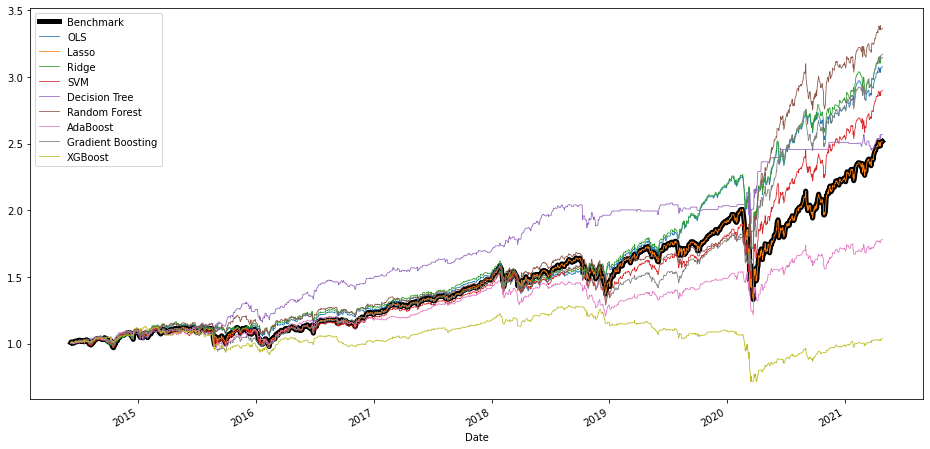

In [323]:
fig, ax = plt.subplots(figsize=(16,8))

np.cumprod(Y_test + 1).plot(ax=ax, label='Benchmark', color='Black', linewidth=5)

np.cumprod(([1 if x > 0 else 0 for x in ols_pred] * Y_test) + 1).plot(ax=ax, label='OLS', linewidth=0.8)
np.cumprod(([1 if x > 0 else 0 for x in lasso_pred] * Y_test) + 1).plot(ax=ax, label='Lasso', linewidth=0.8)
np.cumprod(([1 if x > 0 else 0 for x in ridge_pred] * Y_test) + 1).plot(ax=ax, label='Ridge', linewidth=0.8)
np.cumprod(([1 if x > 0 else 0 for x in svm_pred] * Y_test) + 1).plot(ax=ax, label='SVM', linewidth=0.8)
np.cumprod(([1 if x > 0 else 0 for x in DT_pred] * Y_test) + 1).plot(ax=ax, label='Decision Tree', linewidth=0.8)
np.cumprod(([1 if x > 0 else 0 for x in RF_pred] * Y_test) + 1).plot(ax=ax, label='Random Forest', linewidth=0.8)
np.cumprod(([1 if x > 0 else 0 for x in Ada_pred] * Y_test) + 1).plot(ax=ax, label='AdaBoost', linewidth=0.8)
np.cumprod(([1 if x > 0 else 0 for x in GBR_pred] * Y_test) + 1).plot(ax=ax, label='Gradient Boosting', linewidth=0.8)
np.cumprod(([1 if x > 0 else 0 for x in XGB_pred] * Y_test) + 1).plot(ax=ax, label='XGBoost', linewidth=0.8)

plt.legend()

Further analyze RandomForest and Ridge:

In [336]:
ridge_signal = pd.Series([1 if x > 0 else 0 for x in ridge_pred])
RF_signal = pd.Series([1 if x > 0 else 0 for x in RF_pred])

ridge_turnover = np.sum(np.abs(ridge_signal - ridge_signal.shift(1)))
RF_turnover = np.sum(np.abs(RF_signal - RF_signal.shift(1)))
print(f'Random Forest: Total of {int(RF_turnover)} trades, equaling {(RF_turnover / len(Y_test) * 100).round(2)}% of total total days.')
print(f'Ridge: Total of {int(ridge_turnover)} trades, equaling {(ridge_turnover / len(Y_test) * 100).round(2)}% of total total days.')

Random Forest: Total of 444 trades, equaling 25.78% of total total days.
Ridge: Total of 724 trades, equaling 42.04% of total total days.


In [350]:
print(f'Cumultaive return of Random Forest model: {(np.cumprod(([1 if x > 0 else 0 for x in RF_pred] * Y_test) + 1)[-1] * 100).round(2)}%')
print(f'Cumultaive return of Ridge model: {(np.cumprod(([1 if x > 0 else 0 for x in ridge_pred] * Y_test) + 1)[-1] * 100).round(2)}%')
print(f'Cumultaive return of Holding SPY: {(np.cumprod((Y_test) + 1)[-1] * 100).round(2)}%')

Cumultaive return of Random Forest model: 336.47%
Cumultaive return of Ridge model: 314.67%
Cumultaive return of Holding SPY: 251.71%
